In [12]:
import pandas as pd
import numpy as np

# Charger les données de Google à partir du fichier CSV
file_path = 'donnees_individuelles_yahoo/GOOGL.csv'
df = pd.read_csv(file_path)

# Convertir la colonne 'date' en datetime
df['date'] = pd.to_datetime(df['date'])

# S'assurer que les données sont triées par date
df = df.sort_values('date').reset_index(drop=True)

# Utiliser la colonne 'returns' si elle existe, sinon la calculer
if 'returns' in df.columns:
    # Supprimer les NaNs qui peuvent exister
    returns = df['returns'].dropna()
else:
    # Calculer les rendements quotidiens à partir de 'adj_close'
    returns = df['adj_close'].pct_change().dropna()

# Conserver les dates correspondantes aux rendements valides
dates = df['date'][returns.index]

# Afficher un aperçu des données et des rendements
print("Aperçu des données chargées:")
print(df.head())
print("\nAperçu des rendements calculés:")
print(returns.head())

Aperçu des données chargées:
                       date ticker                secteur  adj_close   returns
0 2012-01-03 05:00:00+00:00  GOOGL  Secteur technologique  16.537838       NaN
1 2012-01-04 05:00:00+00:00  GOOGL  Secteur technologique  16.609169  0.004313
2 2012-01-05 05:00:00+00:00  GOOGL  Secteur technologique  16.378775 -0.013872
3 2012-01-06 05:00:00+00:00  GOOGL  Secteur technologique  16.155342 -0.013642
4 2012-01-09 05:00:00+00:00  GOOGL  Secteur technologique  15.470375 -0.042399

Aperçu des rendements calculés:
1    0.004313
2   -0.013872
3   -0.013642
4   -0.042399
5    0.001093
Name: returns, dtype: float64


Statistiques descriptives des rendements de GOOGL:
   Statistique       Valeur
0      Moyenne     0.000747
1   Écart-type     0.016827
2    Asymétrie     0.387521
3     Kurtosis     8.779184
4  Jarque-Bera  8921.965936
5   JB p-value     0.000000


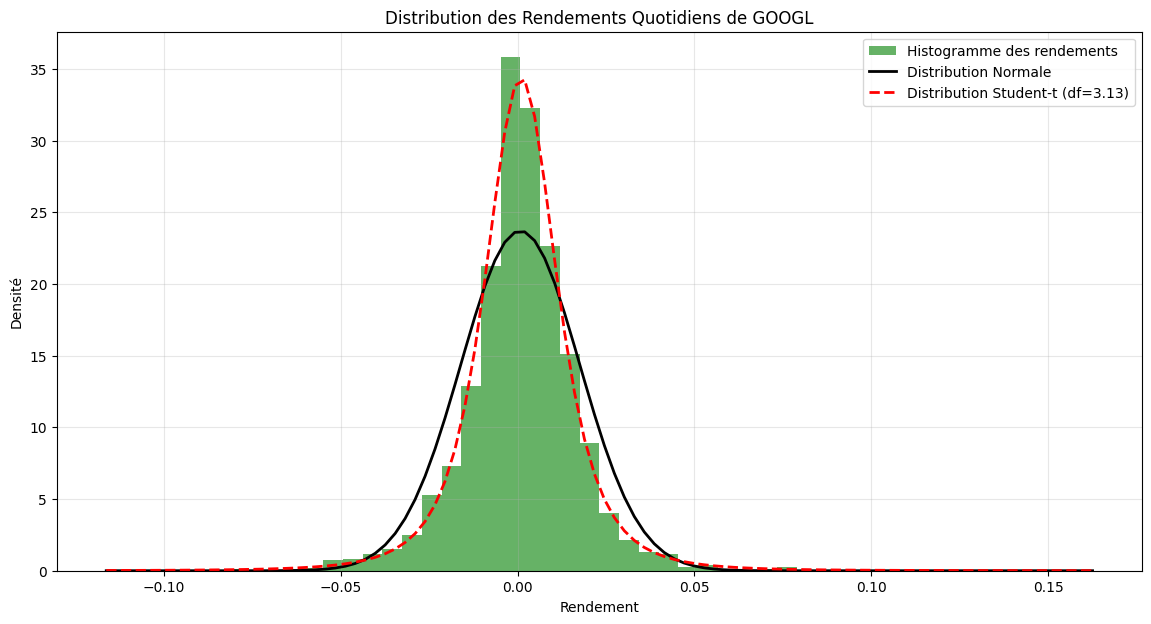

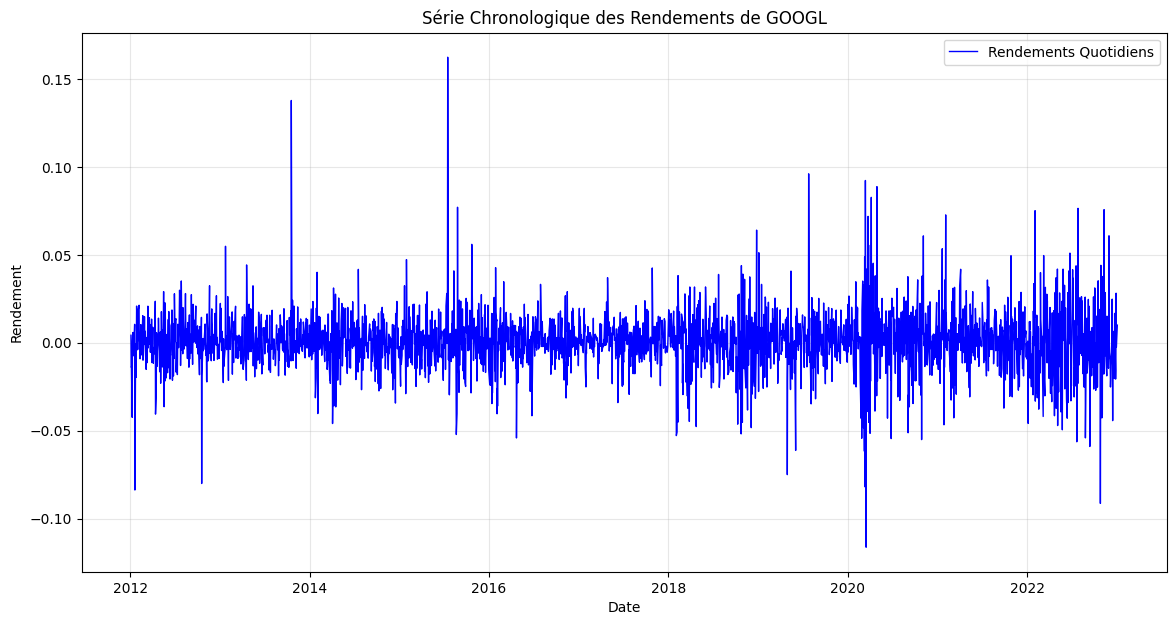

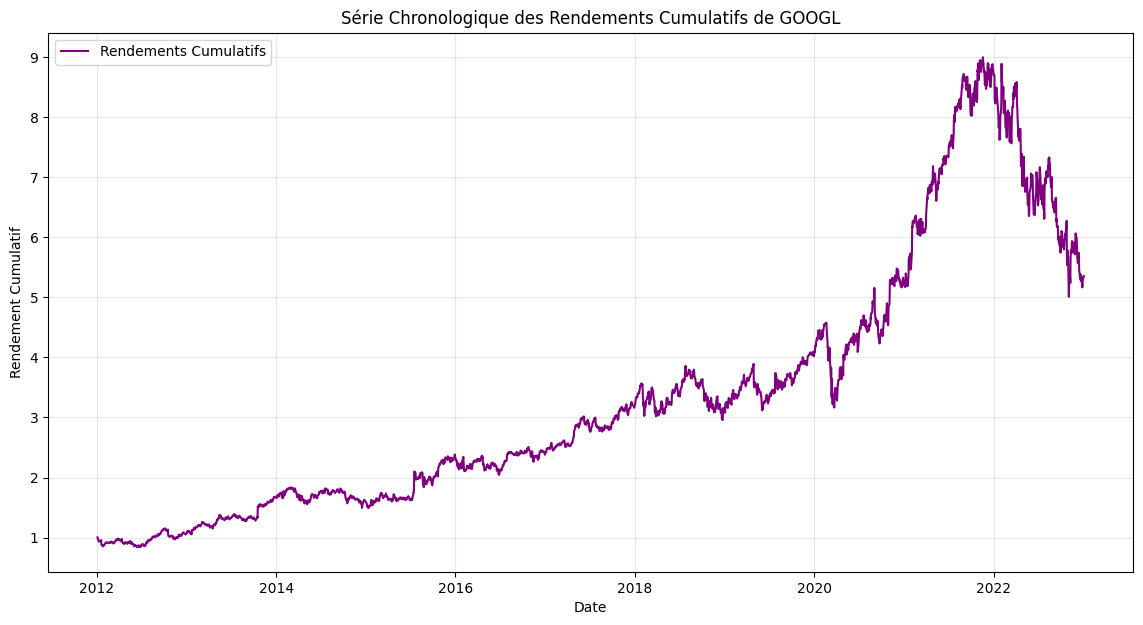

<Figure size 800x600 with 0 Axes>

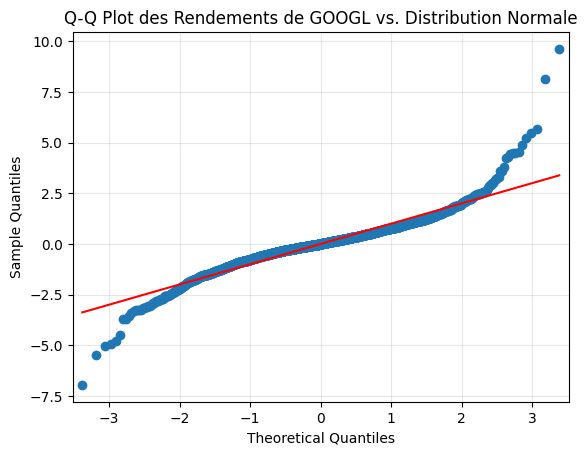

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import t, norm
import pandas as pd
import statsmodels.api as sm

# Calculer les statistiques descriptives
mean_return = returns.mean()
std_return = returns.std()
skewness = returns.skew()
kurt = returns.kurtosis()
jb_stat, jb_pvalue = stats.jarque_bera(returns)

stats_df = pd.DataFrame({
    'Statistique': ['Moyenne', 'Écart-type', 'Asymétrie', 'Kurtosis', 'Jarque-Bera', 'JB p-value'],
    'Valeur': [mean_return, std_return, skewness, kurt, jb_stat, jb_pvalue]
})
print("Statistiques descriptives des rendements de GOOGL:")
print(stats_df)

# 1. Histogramme des rendements avec distributions
plt.figure(figsize=(14, 7))
plt.hist(returns, bins=50, density=True, alpha=0.6, color='g', label='Histogramme des rendements')

# Ajustement de la distribution normale
x = np.linspace(returns.min(), returns.max(), 100)
pdf_normal = norm.pdf(x, mean_return, std_return)
plt.plot(x, pdf_normal, 'k', linewidth=2, label='Distribution Normale')

# Ajustement de la distribution de Student-t
df_student, loc_student, scale_student = t.fit(returns)
pdf_student = t.pdf(x, df_student, loc=loc_student, scale=scale_student)
plt.plot(x, pdf_student, 'r--', linewidth=2, label=f'Distribution Student-t (df={df_student:.2f})')

plt.title('Distribution des Rendements Quotidiens de GOOGL')
plt.xlabel('Rendement')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Série chronologique des rendements
plt.figure(figsize=(14, 7))
plt.plot(dates, returns, label='Rendements Quotidiens', color='blue', lw=1)
plt.title('Série Chronologique des Rendements de GOOGL')
plt.xlabel('Date')
plt.ylabel('Rendement')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Rendements cumulatifs
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(14, 7))
plt.plot(dates, cumulative_returns, label='Rendements Cumulatifs', color='purple', lw=1.5)
plt.title('Série Chronologique des Rendements Cumulatifs de GOOGL')
plt.xlabel('Date')
plt.ylabel('Rendement Cumulatif')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Q-Q plot pour comparer à la distribution normale
plt.figure(figsize=(8, 6))
sm.qqplot(returns, line='s', fit=True)
plt.title('Q-Q Plot des Rendements de GOOGL vs. Distribution Normale')
plt.grid(True, alpha=0.3)
plt.show()



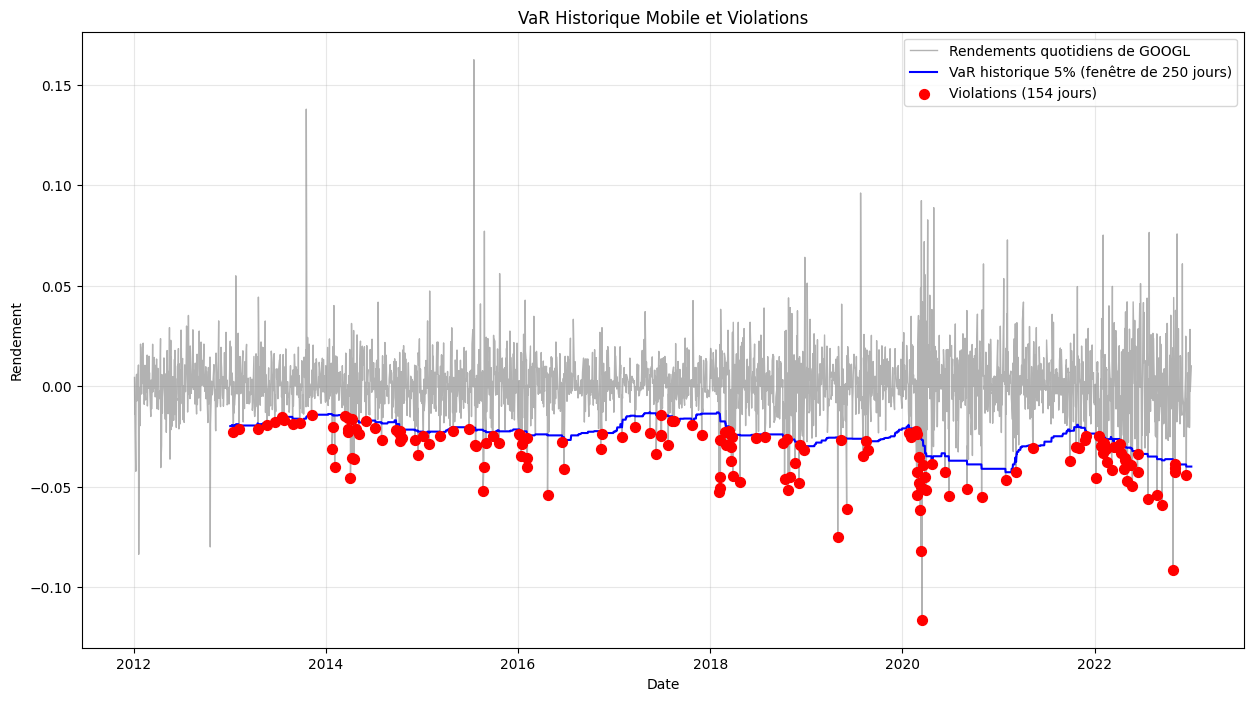

--- Test de Couverture (Fenêtre Mobile de 250 jours) ---
Niveau de VaR (alpha): 5.0%
Nombre d'observations valides: 2519
Nombre de violations attendues: 125.95
Nombre de violations observées: 154
Pourcentage de violations (hits): 6.11%


In [25]:
# --- Question 4(b): VaR Historique avec Fenêtre Mobile ---

# Paramètres
window_size = 250
var_level = 0.05

# 1. Calculer la VaR historique à 5% avec une fenêtre mobile de 250 jours
# La VaR est le quantile des rendements sur la fenêtre glissante.
rolling_var_5 = returns.rolling(window=window_size).quantile(var_level)

# 2. Identifier les violations
# Une violation se produit lorsque le rendement réel est inférieur à la VaR estimée.
# On décale la VaR de 1 pour comparer le rendement de t avec la VaR calculée en t-1.
violations = returns < rolling_var_5.shift(1)
violation_dates = dates[violations]
violation_values = returns[violations]

# 3. Tracer la série chronologique de la VaR et les violations
plt.figure(figsize=(15, 8))

# Tracer les rendements
plt.plot(dates, returns, 
         label='Rendements quotidiens de GOOGL', 
         color='gray', alpha=0.6, lw=1)

# Tracer la VaR mobile
plt.plot(dates, rolling_var_5, 
         label=f'VaR historique {var_level:.0%} (fenêtre de {window_size} jours)', 
         color='blue', lw=1.5)

# Marquer les violations avec des points rouges
plt.scatter(violation_dates, violation_values, 
            color='red', marker='o', s=50, zorder=5, 
            label=f'Violations ({violations.sum()} jours)')

# Configuration du graphique
plt.title('VaR Historique Mobile et Violations')
plt.xlabel('Date')
plt.ylabel('Rendement')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Commentaire sur les résultats et test de couverture
num_obs_rolling = len(rolling_var_5.dropna())
expected_violations_rolling = num_obs_rolling * var_level
actual_violations_rolling = violations.sum()
violation_rate_rolling = actual_violations_rolling / num_obs_rolling

print(f"--- Test de Couverture (Fenêtre Mobile de {window_size} jours) ---")
print(f"Niveau de VaR (alpha): {var_level:.1%}")
print(f"Nombre d'observations valides: {num_obs_rolling}")
print(f"Nombre de violations attendues: {expected_violations_rolling:.2f}")
print(f"Nombre de violations observées: {actual_violations_rolling}")
print(f"Pourcentage de violations (hits): {violation_rate_rolling:.2%}")


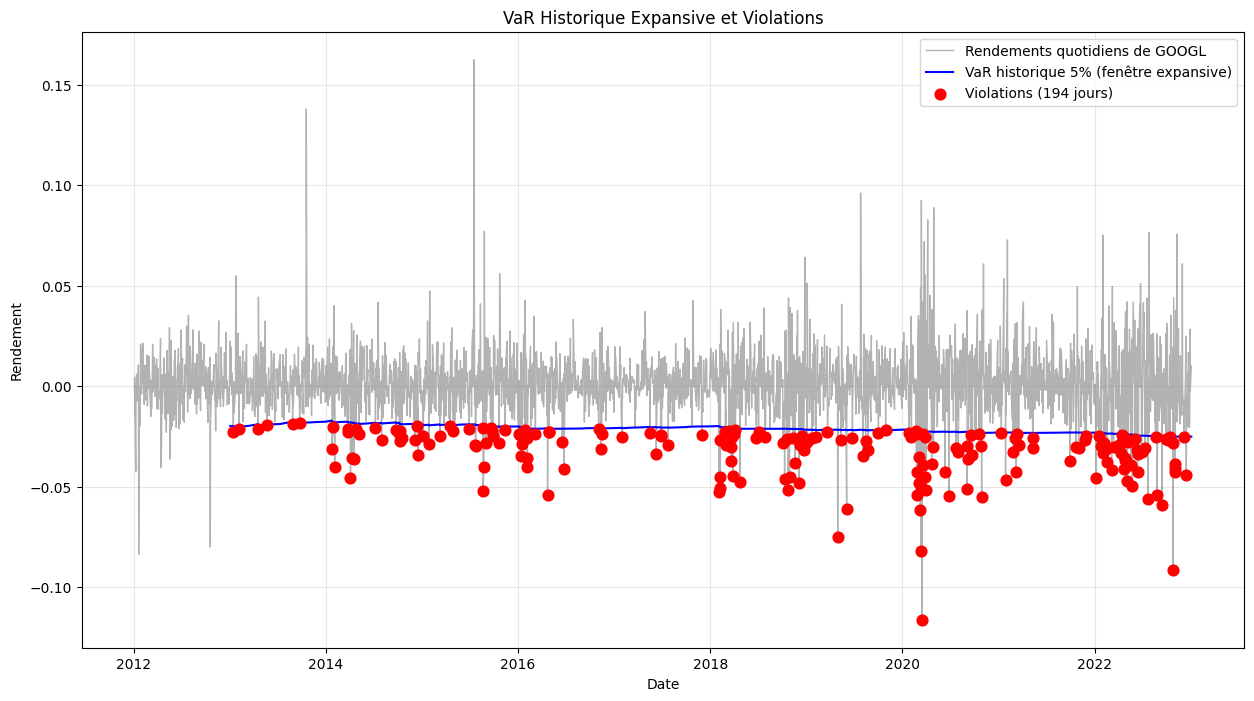

--- Test de Couverture (Fenêtre Expansive, début à 250 jours) ---
Niveau de VaR (alpha): 5.0%
Nombre d'observations valides: 2519
Nombre de violations attendues: 125.95
Nombre de violations observées: 194
Pourcentage de violations (hits): 7.70%


In [26]:
# --- Question 4(c): VaR Historique avec Fenêtre Expansive ---

# Paramètres
initial_window_size = 250
var_level = 0.05

# 1. Calculer la VaR historique avec une fenêtre expansive
# La fenêtre commence à `initial_window_size` et grandit avec le temps.
expanding_var = returns.expanding(min_periods=initial_window_size).quantile(var_level)

# 2. Identifier les violations
# On décale la VaR de 1 pour comparer le rendement de t avec la VaR calculée en t-1.
expanding_violations = returns < expanding_var.shift(1)
expanding_violation_dates = dates[expanding_violations]
expanding_violation_values = returns[expanding_violations]

# 3. Tracer la série chronologique de la VaR et les violations
plt.figure(figsize=(15, 8))

# Tracer les rendements
plt.plot(dates, returns, 
         label='Rendements quotidiens de GOOGL', 
         color='gray', alpha=0.6, lw=1)

# Tracer la VaR expansive
plt.plot(dates, expanding_var, 
         label=f'VaR historique {var_level:.0%} (fenêtre expansive)', 
         color='blue', lw=1.5)

# Marquer les violations
plt.scatter(expanding_violation_dates, expanding_violation_values, 
            color='red', marker='o', s=60, zorder=5, 
            label=f'Violations ({expanding_violations.sum()} jours)')

# Configuration du graphique
plt.title('VaR Historique Expansive et Violations')
plt.xlabel('Date')
plt.ylabel('Rendement')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Commentaire sur les résultats et test de couverture
num_obs_expanding = len(expanding_var.dropna())
expected_violations_expanding = num_obs_expanding * var_level
actual_violations_expanding = expanding_violations.sum()
violation_rate_expanding = actual_violations_expanding / num_obs_expanding

print(f"--- Test de Couverture (Fenêtre Expansive, début à {initial_window_size} jours) ---")
print(f"Niveau de VaR (alpha): {var_level:.1%}")
print(f"Nombre d'observations valides: {num_obs_expanding}")
print(f"Nombre de violations attendues: {expected_violations_expanding:.2f}")
print(f"Nombre de violations observées: {actual_violations_expanding}")
print(f"Pourcentage de violations (hits): {violation_rate_expanding:.2%}")

